In [11]:
# Library imports
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [12]:
mnist = tf.keras.datasets.mnist
train, test = mnist.load_data()

(x_train, y_train), (x_test, y_test) = train, test

In [13]:
image_size = 16

# expand new axis, channel axis 
x_train = np.expand_dims(x_train, axis=-1)

# # [optional]: we may need 3 channel (instead of 1)
# x_train = np.repeat(x_train, 3, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 16
x_train = tf.image.resize(x_train, [image_size, image_size]) # if we want to resize 

print(x_train.shape)
# (60000, 16, 16, 1)

(60000, 16, 16, 1)


In [14]:
train = (x_train, y_train)

dataset = []
label = 0
count = 0

batch_size = 1
num_images = 30

for idx, num in enumerate(list(y_train)):
    if count == num_images:
        break
    if num == label:
        count += 1
        new_x_train = x_train[idx].numpy()
        torch_x_train = torch.from_numpy(new_x_train)
        dataset.append((torch_x_train, label))

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

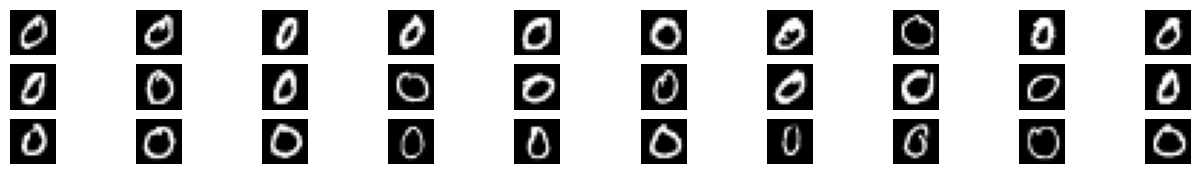

In [15]:
plt.figure(figsize=(image_size,2))

for i in range(num_images):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(3,num_images//3, i + 1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

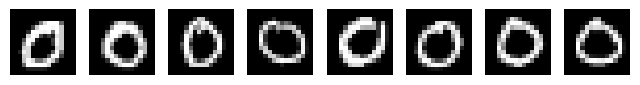

In [16]:
optimal_list_9 = [0, 5, 11, 12, 16, 18, 20, 23]
optimal_list_0 = [4, 5, 11, 13, 17, 21, 22, 29]
optimal_list_7 = [7, 9, 11, 24, 25, 26, 27, 28]
optimal_list_3 = [0, 2, 12, 14, 16, 18, 23, 25]
optimal_list_1 = [1, 2, 3, 6, 14, 17, 23, 25]
optimal_list_2 = [2, 7, 10, 11, 12, 13, 17, 19]
optimal_list_4 = [0, 2, 5, 8, 10, 18, 20, 23]
optimal_list_5 = [11, 13, 15, 17, 19, 22, 26, 29]
optimal_list_6 = [2, 4, 7, 8, 10, 15, 16, 21]
optimal_list_8 = [2, 4, 7, 16, 18, 19, 20, 24]

optimal_list_s = [5]

new_dataset = []
for i in optimal_list_0:
    new_dataset.append(dataset[i])
    
dataset = new_dataset

m = len(optimal_list_0)

plt.figure(figsize=(m, 2))

for i in range(m):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1, m, i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()

In [17]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 256),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            
            nn.Linear(256, 64),
            nn.ReLU(),

            nn.Linear(64, 16),
            nn.ReLU(),

            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [18]:
# Quantum variables
#for 16x16
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 4  # Depth of the parameterised quantum circuit / D
n_generators = 16  # Number of subgenerators for the patch method / N_G

#for 8x8

# n_qubits = 4  # Total number of qubits / N
# n_a_qubits = 1  # Number of ancillary qubits / N_A
# q_depth = 3  # Depth of the parameterised quantum circuit / D
# n_generators = 8  # Number of subgenerators for the patch method / N_G

In [19]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [21]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

In [22]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 450  # Number of training iterations

In [23]:
start = time.time()

discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(num_images, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

losses = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        losses.append([f'{errD:0.3f}', f'{errG:0.3f}'])

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(num_images,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break
end = time.time()
print(f'time taken to execute = {end - start}')

Iteration: 10, Discriminator Loss: 1.383, Generator Loss: 0.683
Iteration: 20, Discriminator Loss: 1.382, Generator Loss: 0.686
Iteration: 30, Discriminator Loss: 1.371, Generator Loss: 0.687
Iteration: 40, Discriminator Loss: 1.374, Generator Loss: 0.689
Iteration: 50, Discriminator Loss: 1.365, Generator Loss: 0.692
Iteration: 60, Discriminator Loss: 1.375, Generator Loss: 0.687
Iteration: 70, Discriminator Loss: 1.343, Generator Loss: 0.702
Iteration: 80, Discriminator Loss: 1.335, Generator Loss: 0.706
Iteration: 90, Discriminator Loss: 1.320, Generator Loss: 0.707
Iteration: 100, Discriminator Loss: 1.322, Generator Loss: 0.719
Iteration: 110, Discriminator Loss: 1.287, Generator Loss: 0.729
Iteration: 120, Discriminator Loss: 1.253, Generator Loss: 0.743
Iteration: 130, Discriminator Loss: 1.229, Generator Loss: 0.748
Iteration: 140, Discriminator Loss: 1.232, Generator Loss: 0.767
Iteration: 150, Discriminator Loss: 1.183, Generator Loss: 0.753
Iteration: 160, Discriminator Loss

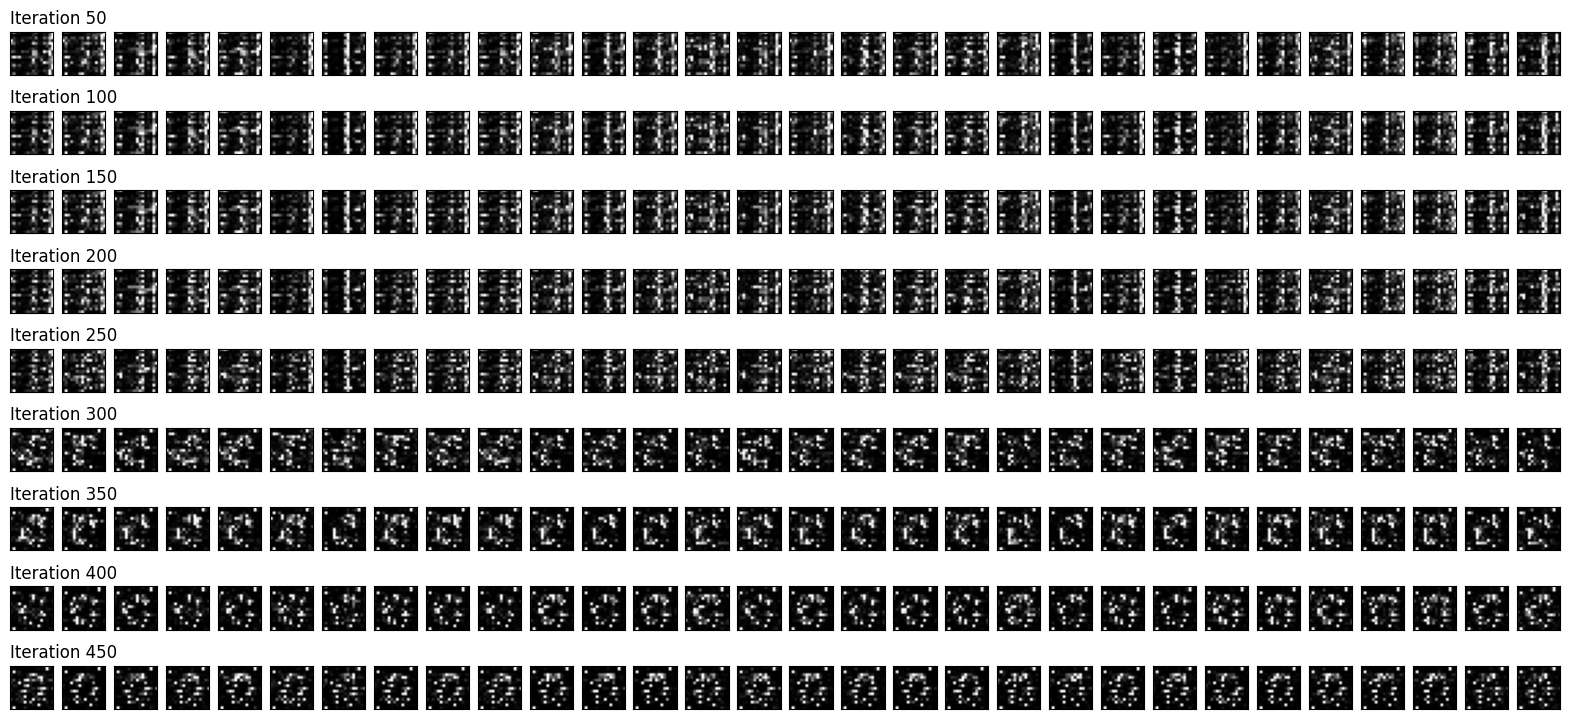

In [24]:
fig = plt.figure(figsize=(20, 10))
outer = gridspec.GridSpec(10, 1, wspace=0.5, hspace=0.4)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()

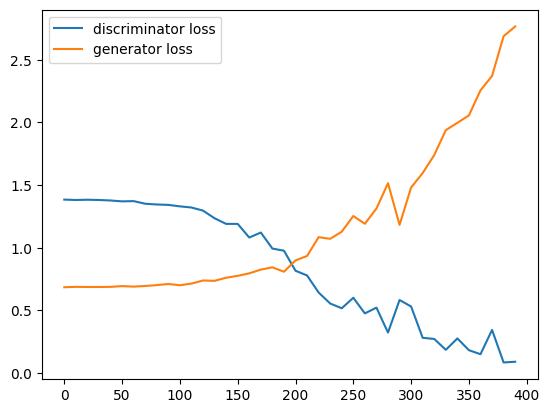

In [25]:
discriminator_loss = [float(losses[i][0]) for i in range(0, 400, 10)]
generator_loss = [float(losses[i][1]) for i in range(0, 400, 10)]

x = [i for i in range(0, 400, 10)]

plt.plot(x, discriminator_loss, label='discriminator loss')
plt.plot(x, generator_loss, label='generator loss')

plt.legend()
plt.show()

In [26]:
torch.save(images, 'results_0_2.pt')